# Classification model

# Imports

In [1]:
import os
import cv2
import json
import pathlib
from tqdm import tqdm
from pprint import pprint

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
import mlflow
import mlflow.pytorch

import matplotlib.pyplot as plt

from torchinfo import summary
import torchvision.transforms as transforms
import torchvision.models as models
from torchsummary import summary
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import seaborn as sns

# Constants

In [2]:
CLASS2ID = {
    "R": 1,
    "N": 1,
    "B": 1,
    "Q": 1,
    "K": 1,
    "P": 1,
    "0": 0,
    "r": 2,
    "n": 2,
    "b": 2,
    "q": 2,
    "k": 2,
    "p": 2
}

current_dir = pathlib.Path.cwd()
ROOT_DIR = current_dir.parent
#REAL_DATASET_NAME = "real_chess_dataset"
REAL_DATASET_NAME = "recorded_dataset"
REAL_DATASET_DIR = ROOT_DIR / "data" / REAL_DATASET_NAME
TEST_TRAIN_RATIO = 0.2

MLFLOW_EXPERIMENT_NAME = "SquaredChessModel"
MLRUNS_DIR = ROOT_DIR / "data" / "mlruns"

# Dataset class

In [5]:
# Constants
SQUARE_SIZE = 299
BOARD_PADDING = 0 # Percentage of padding around the square


def fen2arr(fen):
    # Only use the piece placement part
    fen_piece_placement = fen.split(" ")[
        0
    ]  # rnbqkbnr/pp1ppppp/8/2p5/4P3/5N2/PPPP1PPP/RNBQKB1R b KQkq - 1 2
    board_arr = np.empty((8, 8), dtype=object)
    rows = fen_piece_placement.split("/")
    for i, row in enumerate(rows):
        col = 0
        for char in row:
            if char.isdigit():
                for _ in range(int(char)):
                    board_arr[i, col] = "0"  # empty square
                    col += 1
            else:
                board_arr[i, col] = char
                col += 1
    return board_arr

class ChessSquaredDataset(Dataset):
    def __init__(self, dataset_dir, class2id, video_ids = None, augment_scaling: int=4):
        self.dataset_dir = dataset_dir
        self.class2id = class2id

        # Load all video IDs
        if not video_ids:
            video_ids = []
            for video_dir in dataset_dir.glob("*"):
                if not video_dir.is_dir() or video_dir.name.startswith("."):
                    continue
                video_ids.append(video_dir.name)
        self.video_ids = video_ids

        # Load board image paths and FEN labels
        board_img_paths = []
        fen_and_move_labels = []
        for video_id in self.video_ids:
            imgs_dir = dataset_dir / video_id / "squared"
            fen_path = dataset_dir / video_id / "fen.csv"

            for img_file in imgs_dir.glob("*.jpg"):
                img_name = img_file.stem
                move_number = int(img_name.split("_")[-1])  # Extract move number from filename
                board_img_paths.append(str(img_file))

                if augment_scaling > 1:
                    for _ in range(augment_scaling):
                        fen_and_move_labels.append((fen_path, move_number))
                else:
                    fen_and_move_labels.append((fen_path, move_number))

        self.samples = []

        for img_path, (fen_path, move_number) in zip(board_img_paths, fen_and_move_labels):
            # 64 squares per image
            for row in range(8):
                for col in range(8):
                    self.samples.append((img_path, fen_path, move_number, row, col))

                    
        #self.transform = transforms.ToTensor() # Convert images to tensors (0-255 -> 0-1)
        self.transforms = transforms.Compose([
            transforms.ToTensor(),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(5),
            transforms.RandomResizedCrop(SQUARE_SIZE, scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        ])

        # self.transforms = transforms.Compose([
        #     transforms.ToTensor(),
        #     transforms.RandomAffine(
        #     degrees=5, 
        #     translate=(0.1, 0.1),
        #     scale=(0.8, 1),
        #     shear=1
        # ),
        # transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)])

    def __len__(self):
        return len(self.samples)
    
    
    def __getitem__(self, idx):
        img_path, fen_path, move_number, row, col = self.samples[idx]
        
        # Load the image
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        
        # Crop the board padding
        h, w = img.shape[:2]
        start_h = int(h * BOARD_PADDING // 100)
        start_w = int(w * BOARD_PADDING // 100)
        img = img[start_h:h-start_h, start_w:w-start_w]
        
        # Crop the specific square
        img = cv2.resize(img, (8 * SQUARE_SIZE, 8 * SQUARE_SIZE))
        square_img = img[row*SQUARE_SIZE:(row+1)*SQUARE_SIZE, col*SQUARE_SIZE:(col+1)*SQUARE_SIZE]

        # Load the label
        with open(fen_path, 'r') as f:
            df_fen = pd.read_csv(f)
            
        board_fen = df_fen.loc[df_fen["index"] == move_number, 'fen'].iloc[0]
        square_label = fen2arr(board_fen)[row, col]  # move_number is 1-indexed

        # Move the channel dimension to the front and apply transforms
        square_img_tensor = self.transforms(square_img)  # Convert to tensor (3, 60, 60)

        # Convert label to class ID
        square_label = self.class2id.get(square_label, -1)  # Use -1 for unknown labels
        
        return square_img_tensor, square_label
    



complete_dataset = ChessSquaredDataset(
    dataset_dir=REAL_DATASET_DIR,
    class2id=CLASS2ID
)

train_size = int(TEST_TRAIN_RATIO * len(complete_dataset))
test_size = len(complete_dataset) - train_size
generator = torch.Generator().manual_seed(42)
test_dataset, train_dataset = random_split(complete_dataset, [train_size, test_size], generator=generator)

print(f"Number of samples: {len(complete_dataset)}")
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of testing samples: {len(test_dataset)}")

Number of samples: 4992
Number of training samples: 3994
Number of testing samples: 998


Image shape: (299, 299, 3)
Label: 1


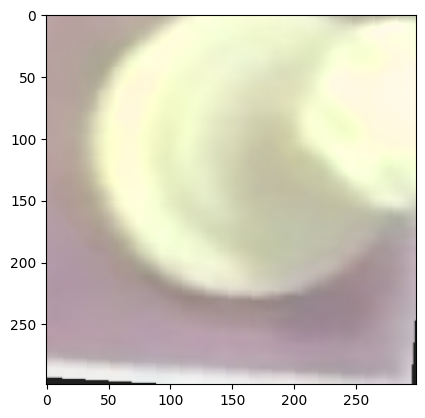

In [6]:
img, label = train_dataset[26]
img = np.transpose(img.numpy(), (1, 2, 0))  # Convert to HWC for visualization
print("Image shape:", img.shape)

print("Label:", label)
plt.imshow(img)
plt.show()

# Data loader

In [7]:
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle= True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle= True)

train_imgs_batch, train_labels_batch = next(iter(train_dataloader))
print(f"Batch image shape: {train_imgs_batch.shape}")
print(f"Batch labels shape: {len(train_labels_batch)}")

print(train_labels_batch)

Batch image shape: torch.Size([64, 3, 299, 299])
Batch labels shape: 64
tensor([0, 2, 0, 0, 0, 1, 0, 0, 0, 2, 2, 0, 1, 0, 2, 0, 2, 0, 1, 1, 0, 0, 2, 0,
        0, 1, 1, 0, 1, 0, 2, 1, 0, 0, 2, 1, 0, 1, 0, 0, 2, 1, 1, 0, 1, 0, 0, 2,
        0, 2, 2, 0, 2, 0, 2, 2, 0, 1, 0, 1, 1, 1, 0, 0])


# Classification model

## Dimensions

- Convolution without stride:
    $$
    Out = (W_{in} + 2P) - K + 1
    $$
- Convolution with stride
    $$
    Out = \left\lfloor \frac{W_{in} + 2P - K}{S} \right\rfloor + 1
    $$

In [8]:
class SmallAlexNet(nn.Module):
    def __init__(self, num_classes=13, input_size=(3, 60, 60)):
        super(SmallAlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=1, padding=2),  # (54, 54, 96)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (26, 26, 96)
            nn.Conv2d(96, 256, kernel_size=5, padding=2),  # (26, 26, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (12, 12, 256)
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),  # (12, 12, 384)
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),  # (12, 12, 384)
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),  # (12, 12, 256)
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),  # (5, 5, 256) = 6400 features
        )

        with torch.no_grad():
            # Calculate the output size after the feature extractor
            sample_input = torch.zeros(1, *input_size)
            output_features_shape = self.features(sample_input).shape[1:]

        output_features_size = np.prod(output_features_shape)
        print("Output features size:", output_features_shape)
        print("Output features size:", output_features_size)

        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(output_features_size, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.flatten(1)
        x = self.classifier(x)
        return x


model = SmallAlexNet(num_classes=3, input_size=(3, 60, 60))
summary(model)

Output features size: torch.Size([256, 5, 5])
Output features size: 6400


Layer (type:depth-idx)                   Param #
SmallAlexNet                             --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       34,944
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
│    └─Conv2d: 2-4                       614,656
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
│    └─Conv2d: 2-7                       885,120
│    └─ReLU: 2-8                         --
│    └─Conv2d: 2-9                       1,327,488
│    └─ReLU: 2-10                        --
│    └─Conv2d: 2-11                      884,992
│    └─ReLU: 2-12                        --
│    └─MaxPool2d: 2-13                   --
├─Sequential: 1-2                        --
│    └─Dropout: 2-14                     --
│    └─Linear: 2-15                      26,218,496
│    └─ReLU: 2-16                        --
│    └─Dropout: 2-17                     --
│    └─Linear: 2-18                  

## Pretrained models

In [25]:
pre_trained_model = models.inception_v3(pretrained=True, aux_logits=True)
#summary(pre_trained_model, input_size=(1, 3, 60, 60))

def print_model_summary(model):
    for name, module in model.named_modules():
        print(f"{name} : {module.__class__.__name__}")

# print_model_summary(pre_trained_model)

# 
summary(pre_trained_model, input_size=(3, 299, 299))  # (Channels, Height, Width)

/Users/alexquiroga/anaconda3/envs/computer_vision/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alexquiroga/anaconda3/envs/computer_vision/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 149, 149]             864
       BatchNorm2d-2         [-1, 32, 149, 149]              64
       BasicConv2d-3         [-1, 32, 149, 149]               0
            Conv2d-4         [-1, 32, 147, 147]           9,216
       BatchNorm2d-5         [-1, 32, 147, 147]              64
       BasicConv2d-6         [-1, 32, 147, 147]               0
            Conv2d-7         [-1, 64, 147, 147]          18,432
       BatchNorm2d-8         [-1, 64, 147, 147]             128
       BasicConv2d-9         [-1, 64, 147, 147]               0
        MaxPool2d-10           [-1, 64, 73, 73]               0
           Conv2d-11           [-1, 80, 73, 73]           5,120
      BatchNorm2d-12           [-1, 80, 73, 73]             160
      BasicConv2d-13           [-1, 80, 73, 73]               0
           Conv2d-14          [-1, 192,

Freeze mdoel up to a certain layer

In [26]:
for name, parameter in pre_trained_model.named_parameters():
    parameter.requires_grad = False
    if 'Mized_7c' in name:
        break

Modify the existing fully connected layer

In [27]:
num_ftrs = pre_trained_model.fc.in_features
pre_trained_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 3)
)

#model = pre_trained_model

In [28]:
model = pre_trained_model

dummy_input = torch.randn(1, 3, 350, 350)

with torch.no_grad():
    model(dummy_input)

# Training

In [29]:
def train_loop(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)
    model.train()  # Set model to training mode

    train_loss, correct = 0, 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Forward pass
        pred = model(X)
        if isinstance(pred, tuple) or hasattr(pred, 'logits'):
            # For InceptionV3 with aux_logits=True
            pred = pred.logits if hasattr(pred, 'logits') else pred[0]

        loss = loss_fn(pred, y)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Log progress every 10 batches
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            mlflow.log_metric("train_loss", loss, step=current)

    avg_train_loss = train_loss / len(dataloader)
    train_accuracy = correct / size

    return avg_train_loss, train_accuracy


def test_loop(dataloader, model, loss_fn, device):
    model.eval()  # Set model to evaluation mode
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)  # Get logits (no probabilities)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    avg_test_loss = test_loss / num_batches
    test_accuracy = correct / size

    print(
        f"Test Error: Accuracy: {avg_test_loss:.4f}, Avg loss: {avg_test_loss:.4f} \n"
    )

    return avg_test_loss, test_accuracy


def train_model(
    model, train_dataloader, test_dataloader, device, num_epochs=10, learning_rate=1e-3
):
    loss_fn = (
        nn.CrossEntropyLoss()
    )  # Applies softmax so no need to do add softmax to the model output
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Log hyperparameters
    mlflow.log_param("num_epochs", num_epochs)
    mlflow.log_param("learning_rate", learning_rate)

    # Best model accuracy
    best_test_accuracy = 0.0

    # for epoch in tqdm(range(num_epochs), desc="Training"):
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1:>4d}/{num_epochs:>4d}\n-------------------------------")

        avg_train_loss, avg_train_accuracy = train_loop(
            train_dataloader, model, loss_fn, optimizer, device
        )
        avg_test_loss, avg_test_accuracy = test_loop(
            test_dataloader, model, loss_fn, device
        )

        print(
            f"Avg Train Loss: {avg_train_loss:.4f}, Avg Test Loss: {avg_test_loss:.4f}"
        )
        print(
            f"Avg Train Accuracy: {avg_train_accuracy:.4f}, Avg Test Accuracy: {avg_test_accuracy:.4f}\n"
        )

        # Log metrics for each epoch
        mlflow.log_metric("avg_train_loss", avg_train_loss, step=epoch)
        mlflow.log_metric("avg_test_loss", avg_test_loss, step=epoch)
        mlflow.log_metric("train_accuracy", avg_train_accuracy, step=epoch)
        mlflow.log_metric("test_accuracy", avg_test_accuracy, step=epoch)

        # Save best model
        if avg_test_accuracy > best_test_accuracy:
            best_test_accuracy = avg_test_accuracy
            mlflow.pytorch.log_model(model, "best_model")
            print(
                f"Best model updated at epoch {epoch+1} with test accuracy {best_test_accuracy:.4f}"
            )

    # Log the trained model
    mlflow.pytorch.log_model(model, "last_model")

    print("Done!")

In [30]:
# Training
print("Starting training...")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")  # Apple GPU
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

# Set save directory
print("Mlruns dir: ", MLRUNS_DIR)
mlflow.set_tracking_uri("file://" + str(MLRUNS_DIR))

# Set experiment
mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)

# Training and logging
with mlflow.start_run():

    # Create and prepare model
    model = model.to(device)

    # Train the model
    train_model(
        model,
        train_dataloader,
        test_dataloader,
        device=device,
        num_epochs=2,
        learning_rate=1e-3,
    )

Starting training...
Using device: mps
Mlruns dir:  /Users/alexquiroga/Storage/Github/DEEP_LEARNING/COMPUTER_VISION/chess-vision/chess-main/data/mlruns
Epoch    1/   2
-------------------------------
loss: 1.083327 [    0/ 3994]
loss: 0.916312 [  640/ 3994]
loss: 0.866332 [ 1280/ 3994]


KeyboardInterrupt: 